## Lab 3  
**Name:** Ammar Aakel  
**ISU:** 407315  

### Introduction

In this lab, we implement the **Potential Field Method** for robot path planning. The objective is to move a robot from a defined start point to a goal point while avoiding obstacles in the environment using attractive and repulsive potential fields.

### Libraries Used

- `math.pi`: Provides mathematical constants like π.
- `numpy`: Used for numerical computations, matrix operations, and array handling.
- `matplotlib.pyplot` and `mpl_toolkits.mplot3d`: Used for 2D and 3D plotting to visualize the robot's path, obstacles, and potential fields.
- `roboticstoolbox`: Provides robotics-specific tools and functions for modeling and simulation.
- `spatialmath` and `spatialmath.base`: Used for representing and transforming spatial coordinates (e.g., SE(3) transformations).


In [51]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt
import roboticstoolbox as rtb
from spatialmath import SE3
import spatialmath.base as smb
from mpl_toolkits.mplot3d import Axes3D

### Potential Field Functions

The following two functions compute the **attractive** and **repulsive** potential fields in a 3D workspace:

- `compute_attractive_potential(X, Y, Z, goal, D_goal, K1, K2)`:
  - This function calculates the **attractive potential** guiding the robot toward the goal.
  - If the distance to the goal is less than or equal to a threshold $D_{\text{goal}}$, a linear potential is used:
    $$ U_{\text{att}} = K_1 \cdot d $$
  - Otherwise, a quadratic potential is applied:
    $$ U_{\text{att}} = \frac{1}{2} K_2 \cdot d^2 $$
  - where $d$ is the Euclidean distance from each point $(X, Y, Z)$ to the goal.

- `compute_repulsive_potential(X, Y, Z, obstacles, K_{\text{rep}}, d_0)`:
  - This function computes the **repulsive potential** that pushes the robot away from obstacles.
  - For each obstacle position $(x_{\text{obs}}, y_{\text{obs}}, z_{\text{obs}})$, it calculates the distance $d$ from the obstacle.
  - If $d \leq d_0$, a repulsive potential is applied:
    $$ U_{\text{rep}} = \frac{1}{2} K_{\text{rep}} \left( \frac{1}{d} - \frac{1}{d_0} \right)^2 $$
  - Otherwise, the repulsive potential is zero.


In [ ]:

def compute_attractive_potential(X, Y, Z, goal, D_goal, K1, K2):

    x_goal, y_goal, z_goal = goal
    d = np.sqrt((X - x_goal)**2 + (Y - y_goal)**2 + (Z - z_goal)**2)
    U_att = np.where(d <= D_goal, K1 * d, 0.5 * K2 * d**2)
    return U_att

def compute_repulsive_potential(X, Y, Z, obstacles, K_rep, d0):

    U_rep = np.zeros_like(X)
    for obs_x, obs_y, obs_z in obstacles:
        d = np.sqrt((X - obs_x)**2 + (Y - obs_y)**2 + (Z - obs_z)**2)
        d = np.clip(d, 1e-6, None)
        U_rep += np.where(d <= d0, 0.5 * K_rep * (1/d - 1/d0)**2, 0)
    return U_rep


### Numerical Gradient Computation

The function `compute_numerical_gradient(U, h=1.0)` calculates the **numerical gradient** of a 3D scalar potential field $U$ using **central differences** for interior points and **forward/backward differences** at the boundaries.

The gradient components $\nabla U = [\partial U / \partial x,\ \partial U / \partial y,\ \partial U / \partial z]$ are computed as follows:

- **Central difference (for interior points):**
  $$
  \frac{\partial U}{\partial x} \approx \frac{U(x+h, y, z) - U(x-h, y, z)}{2h}
  $$
  $$
  \frac{\partial U}{\partial y} \approx \frac{U(x, y+h, z) - U(x, y-h, z)}{2h}
  $$
  $$
  \frac{\partial U}{\partial z} \approx \frac{U(x, y, z+h) - U(x, y, z-h)}{2h}
  $$

- **Forward difference (at the lower boundary):**
  $$
  \frac{\partial U}{\partial x} \bigg|_{x_0} \approx \frac{U(x+h, y, z) - U(x, y, z)}{h}
  $$

- **Backward difference (at the upper boundary):**
  $$
  \frac{\partial U}{\partial x} \bigg|_{x_n} \approx \frac{U(x, y, z) - U(x-h, y, z)}{h}
  $$

This method is repeated for the $y$ and $z$ directions, providing a complete vector field representing the gradient of the potential function, which can be used to determine the direction of movement.


In [ ]:


def compute_numerical_gradient(U, h=1.0):

    grad_x = np.zeros_like(U)
    grad_y = np.zeros_like(U)
    grad_z = np.zeros_like(U)

    grad_x[1:-1, :, :] = (U[2:, :, :] - U[:-2, :, :]) / (2 * h)
    grad_y[:, 1:-1, :] = (U[:, 2:, :] - U[:, :-2, :]) / (2 * h)
    grad_z[:, :, 1:-1] = (U[:, :, 2:] - U[:, :, :-2]) / (2 * h)

    grad_x[0, :, :] = (U[1, :, :] - U[0, :, :]) / h
    grad_x[-1, :, :] = (U[-1, :, :] - U[-2, :, :]) / h

    grad_y[:, 0, :] = (U[:, 1, :] - U[:, 0, :]) / h
    grad_y[:, -1, :] = (U[:, -1, :] - U[:, -2, :]) / h

    grad_z[:, :, 0] = (U[:, :, 1] - U[:, :, 0]) / h
    grad_z[:, :, -1] = (U[:, :, -1] - U[:, :, -2]) / h

    return grad_x, grad_y, grad_z




### Selecting the Next Move Based on Gradient Force

The `select_next_move_by_force` function chooses the next position by finding the direction with the **steepest potential drop**, simulating motion along the strongest attractive force.

The force toward each neighbor is computed as:

$$
F = \frac{U_{\text{current}} - U_{\text{neighbor}}}{\sqrt{dx^2 + dy^2 + dz^2}}
$$

The neighbor with the **maximum force** is selected, guiding the robot efficiently toward the goal while avoiding obstacles.


In [54]:
def select_next_move_by_force(potential_field, ix, iy, iz, motion):

    max_force = -np.inf
    best_ix, best_iy, best_iz = ix, iy, iz
    current_potential = potential_field[ix, iy, iz]

    for dx, dy, dz in motion:
        nx, ny, nz = ix + dx, iy + dy, iz + dz
        if 0 <= nx < potential_field.shape[0] and 0 <= ny < potential_field.shape[1] and 0 <= nz < potential_field.shape[2]:
            neighbor_potential = potential_field[nx, ny, nz]
            delta_p = current_potential - neighbor_potential
            step_length = np.sqrt(dx**2 + dy**2 + dz**2)
            force = delta_p / step_length
            if force > max_force:
                max_force = force
                best_ix, best_iy, best_iz = nx, ny, nz

    return best_ix, best_iy, best_iz

### Path Planning via Potential Field

The `plan_path` function computes a path from a start point to a goal by following the negative gradient of the total potential field `U_total`.

- It converts positions to grid indices using `pos_to_index`.
- At each step, it chooses the neighboring voxel with the steepest potential drop.
- The path continues until the robot reaches the goal or gets trapped in a local minimum.

This simulates obstacle avoidance and goal-seeking behavior in a 3D environment.


In [ ]:

def plan_path(start, goal, U_total, X, Y, Z, step_size=1.0, max_steps=10000):
    path = [start.copy()]
    current_pos = start.copy()

    def pos_to_index(pos):
        xi = np.argmin(np.abs(X[:, 0, 0] - pos[0]))
        yi = np.argmin(np.abs(Y[0, :, 0] - pos[1]))
        zi = np.argmin(np.abs(Z[0, 0, :] - pos[2]))
        return xi, yi, zi

    motion = [(dx, dy, dz) for dx in [-1, 0, 1]
                          for dy in [-1, 0, 1]
                          for dz in [-1, 0, 1]
                          if not (dx == 0 and dy == 0 and dz == 0)]

    for _ in range(max_steps):
        ix, iy, iz = pos_to_index(current_pos)
        next_ix, next_iy, next_iz = select_next_move_by_force(U_total, ix, iy, iz, motion)

        if (next_ix, next_iy, next_iz) == (ix, iy, iz):
            print("⚠️ Trapped in local minimum.")
            break

        next_pos = np.array([
            X[next_ix, 0, 0],
            Y[0, next_iy, 0],
            Z[0, 0, next_iz]
        ])
        path.append(next_pos.copy())
        current_pos = next_pos

        if np.linalg.norm(current_pos - goal) < step_size:
            print("✅ Reached the goal!")
            break

    return np.array(path)


Next line was made to ensure the `plt.show` views the wanted figure

In [56]:
%matplotlib inline

### Workspace Setup

The 3D grid spans from -10 to 10 in all directions, with a resolution of 0.5 units. The robot starts at **(-10, -10, 10)** and aims to reach the goal at **(10, 10, -10)** while avoiding five defined obstacle points located in the workspace.

In [ ]:
x = np.arange(-10, 10, 0.5)
y = np.arange(-10, 10, 0.5)
z = np.arange(-10, 10, 0.5)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

start_pos = np.array([-10.0, -10.0, 10.0])
goal_pos = np.array([10.0, 10.0, -10.0])

obstacles = [
    (3.0, 4.0, -2.0),
    (6.0, 7.0, -6.0),
    (-2.0, -3.0, 1.0),
    (-6.0, -6.0, 6.0),
    (0.0, 0.0, 0.0)
]


### Potential Field Parameters and Path Planning

The attractive and repulsive potentials are computed with parameters:
- $D_{\text{goal}} = 5.0$ (radius near goal for linear potential),
- $K_1 = 2.0$, $K_2 = 1.0$ (attractive gains),
- $K_{\text{rep}} = 50.0$ (repulsive strength),
- $d_0 = 5.0$ (obstacle influence radius).

The total potential field $U_{\text{total}}$ is the sum of attractive and repulsive components. Its negative gradient $\mathbf{F} = -\nabla U_{\text{total}}$ guides the path planning from start to goal while avoiding obstacles.


In [62]:

D_goal = 5.0        # Radius near goal with linear attractive potential
K1, K2 = 2.0, 1.0   # Attractive potential constants
K_rep = 50.0        # Repulsive potential strength
d0 = 5.0            # Influence distance of obstacles


U_att_total = compute_attractive_potential(X, Y, Z, goal_pos, D_goal, K1, K2)
U_rep_total = compute_repulsive_potential(X, Y, Z, obstacles, K_rep, d0)
U_total = U_att_total + U_rep_total

F_x, F_y, F_z = compute_numerical_gradient(U_total, h=0.5)
F_x, F_y, F_z = -F_x, -F_y, -F_z
F_total = np.sqrt(F_x**2 + F_y**2 + F_z**2)

path = plan_path(start_pos, goal_pos, U_total, X, Y, Z)


✅ Reached the goal!


### Visualization of the Planned Path in 3D

The following plot illustrates the robot's path planned using the potential field method, axes are labeled, and the 3D workspace is bounded within the defined grid limits to provide spatial context.


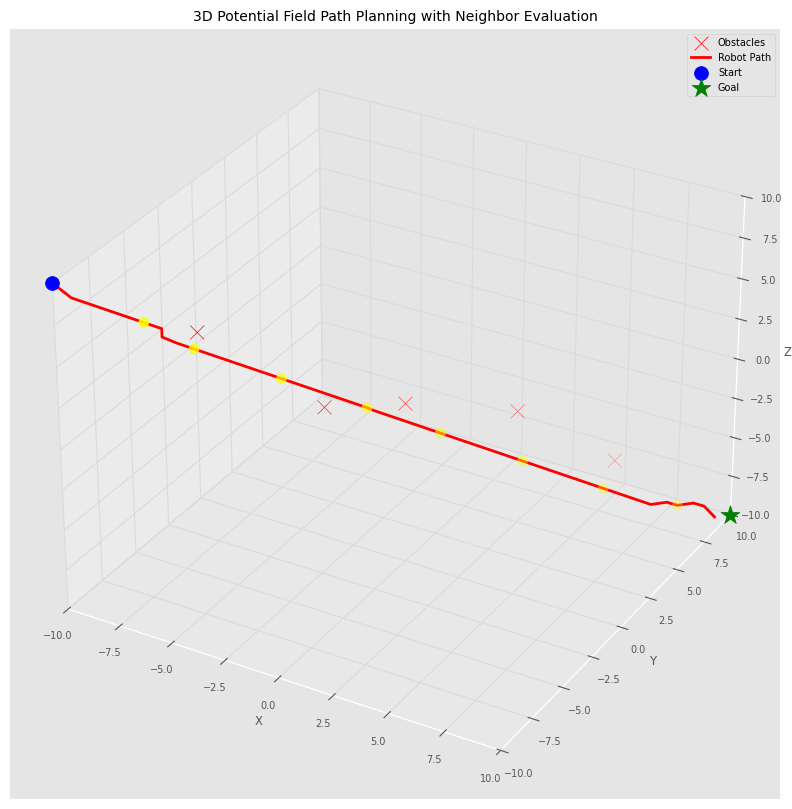

In [63]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

obs_x, obs_y, obs_z = zip(*obstacles)
ax.scatter(obs_x, obs_y, obs_z, c='red', marker='x', s=100, label='Obstacles')

ax.plot(path[:, 0], path[:, 1], path[:, 2], 'r-', linewidth=2, label='Robot Path')
ax.scatter(path[::5, 0], path[::5, 1], path[::5, 2], c='yellow', s=50) 


ax.scatter(*start_pos, c='blue', marker='o', s=100, label='Start')
ax.scatter(*goal_pos, c='green', marker='*', s=200, label='Goal')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_title('3D Potential Field Path Planning with Neighbor Evaluation')
ax.legend()
ax.grid(True)

plt.show()

### 2D Projections of the Planned Path

These three plots show the robot's path projected onto the X–Y, X–Z, and Y–Z planes. 

They help verify that the robot avoids obstacles from all perspectives, since collisions can be hard to detect in the 3D view alone.


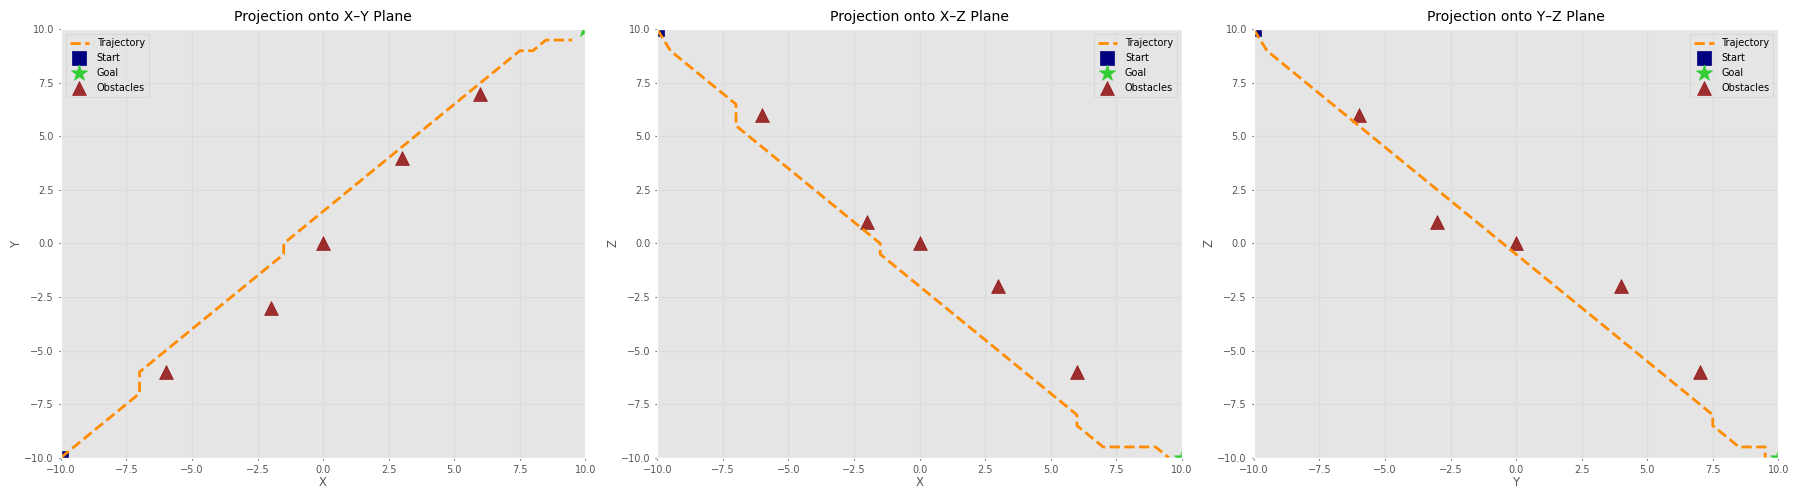

In [ ]:


fig, axes = plt.subplots(1, 3, figsize=(18, 5))


ax = axes[0]
ax.plot(path[:, 0], path[:, 1], color='darkorange', linestyle='--', linewidth=2, label='Trajectory')
ax.scatter([start_pos[0]], [start_pos[1]], color='navy', marker='s', s=100, label='Start')
ax.scatter([goal_pos[0]], [goal_pos[1]], color='limegreen', marker='*', s=150, label='Goal')
ox, oy, oz = zip(*obstacles)
ax.scatter(ox, oy, color='darkred', marker='^', s=100, alpha=0.8, label='Obstacles')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Projection onto X–Y Plane')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.legend()
ax.grid(True)

########
ax = axes[1]
ax.plot(path[:, 0], path[:, 2], color='darkorange', linestyle='--', linewidth=2, label='Trajectory')
ax.scatter([start_pos[0]], [start_pos[2]], color='navy', marker='s', s=100, label='Start')
ax.scatter([goal_pos[0]], [goal_pos[2]], color='limegreen', marker='*', s=150, label='Goal')
ax.scatter(ox, oz, color='darkred', marker='^', s=100, alpha=0.8, label='Obstacles')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('Projection onto X–Z Plane')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.legend()
ax.grid(True)

############
ax = axes[2]
ax.plot(path[:, 1], path[:, 2], color='darkorange', linestyle='--', linewidth=2, label='Trajectory')
ax.scatter([start_pos[1]], [start_pos[2]], color='navy', marker='s', s=100, label='Start')
ax.scatter([goal_pos[1]], [goal_pos[2]], color='limegreen', marker='*', s=150, label='Goal')
ax.scatter(oy, oz, color='darkred', marker='^', s=100, alpha=0.8, label='Obstacles')

ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_title('Projection onto Y–Z Plane')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


### Conclusion

The potential field method successfully planned a collision-free path from start to goal while avoiding obstacles. Gradient-based navigation efficiently guided the robot through the workspace. Visualizations in 3D and planar projections confirmed safe traversal without collisions.
